In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import (
    r2_score, mean_absolute_error, accuracy_score, f1_score, 
    precision_score, recall_score, roc_auc_score, precision_recall_curve, 
    auc, roc_curve
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
import torch
import torch.nn as nn
import torch.optim as optim

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
print("Kütüphaneler ve Ayarlar Hazır.")

Kütüphaneler ve Ayarlar Hazır.


In [2]:
# veri setimizi pandas ile okuyorum
try:
    df_raw = pd.read_csv('ekip_odevi_ham_veri_30k.csv')
    print(f"Veri seti yüklendi. Boyut: {df_raw.shape}")
except FileNotFoundError:
    print("Hata: Dosya bulunamadı.")

Veri seti yüklendi. Boyut: (30000, 17)


In [3]:
# veri temizliği fonksiyonum
# veri setindeki kirli karakterleri temizlemek ve sayısal dönüşümler için fonksiyon yazıyorum

def robust_clean(df_input):
    df = df_input.copy()
    
    # string (object) kolonları temizliyoruz
    for col in df.select_dtypes(include=['object']).columns:
        # para birimi işaretlerini ve virgülleri kaldırıp boşlukları temizliyorum
        df[col] = df[col].astype(str).str.replace(r'[£$€,]', '', regex=True).str.strip()
        
        # "nan" veya "None" gibi string olarak gelmiş boş değerleri gerçek NaN yapıyorum
        df[col] = df[col].replace({'nan': np.nan, 'None': np.nan, '': np.nan})

    # sayısal olması gereken ama string görünen kolonları dönüştürüyorum
    # errors='coerce' diyerek dönüşemeyenleri NaN yapıyoruz ki kod patlamasın
    numeric_candidates = ['price', 'mileage', 'tax', 'mpg', 'engineSize']
    for col in numeric_candidates:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    return df

if 'df_raw' in locals():
    print("Veri temizliği ve filtreleme işlemi başlatılıyor.")
    
    df_clean = df_raw.copy()
    df_clean = robust_clean(df_clean)
    
    # tekrar eden satırları siliyorum
    ilk_boyut = len(df_clean)
    df_clean = df_clean.drop_duplicates().reset_index(drop=True)
    silinen = ilk_boyut - len(df_clean)
    
    print(f"- Temizlik tamamlandı.")
    print(f"- {silinen} adet tekrar eden kayıt silindi.")
    print(f"- Yeni Veri Seti Boyutu: {df_clean.shape}")
    
    # veri tiplerine bakalım
    print("\nTemizlik Sonrası Kritik Sütunların Veri Tipleri:")
    print(df_clean[['price', 'mileage', 'tax', 'mpg', 'engineSize']].dtypes)
    
    display(df_clean.head())
else:
    print("HATA: 'df_raw' bulunamadı.")

Veri temizliği ve filtreleme işlemi başlatılıyor.
- Temizlik tamamlandı.
- 301 adet tekrar eden kayıt silindi.
- Yeni Veri Seti Boyutu: (29699, 17)

Temizlik Sonrası Kritik Sütunların Veri Tipleri:
price         float64
mileage       float64
tax           float64
mpg           float64
engineSize    float64
dtype: object


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,marka,tax(£),fuel type,engine size,mileage2,fuel type2,engine size2,reference
0,Kamiq,2019.0,21990.0,Semi-Auto,563.0,Diesel,145.0,52.3,1.6,skoda,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Q5,2016.0,20498.0,Semi-Auto,33657.0,Diesel,200.0,47.1,2.0,audi,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Touareg,2019.0,39995.0,Semi-Auto,7000.0,Diesel,145.0,34.5,3.0,vw,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Aygo,2019.0,8690.0,Manual,2438.0,Petrol,145.0,56.5,1.0,toyota,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,S-MAX,2020.0,34498.0,Semi-Auto,4623.0,Diesel,145.0,43.5,2.0,ford,NaN,NaN,NaN,NaN,NaN,NaN,NaN


IQR ile Aykırı Değer Temizliği Başlıyor.
- Hesaplanan İstatistiksel Alt Sınır: -5600.00
- Uygulanan Mantıksal Alt Sınır: 100.00
- Üst Sınır: 36880.00
- Filtreleme sonucu 1095 adet aykırı veri elendi.
- Analize hazır veri boyutu: (28602, 17)


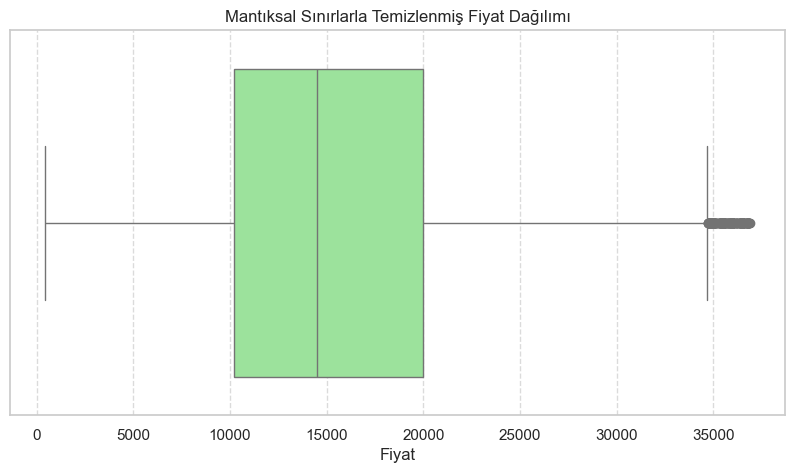

In [4]:
#  veri Hazırlama
df_clean['price'] = pd.to_numeric(df_clean['price'], errors='coerce')
df_clean = df_clean.dropna(subset=['price'])

print("IQR ile Aykırı Değer Temizliği Başlıyor.")
filtre_oncesi = len(df_clean)

#  IQR Hesaplama
Q1 = df_clean['price'].quantile(0.25)
Q3 = df_clean['price'].quantile(0.75)
IQR = Q3 - Q1

#  sınırları Belirleme ve Negatif Değer Kontrolü
# İstatistiksel alt sınır negatif çıkarsa, onu 100 (veya 0) olarak güncelle
hesaplanan_alt = Q1 - 1.5 * IQR
alt_sinir = max(100, hesaplanan_alt) # Fiyat 100'den küçük olamaz
ust_sinir = Q3 + 1.5 * IQR

# filtreleme Uygulaması
df_clean = df_clean[(df_clean['price'] >= alt_sinir) & (df_clean['price'] <= ust_sinir)]

# sonuçlar
silinen_adet = filtre_oncesi - len(df_clean)
print(f"- Hesaplanan İstatistiksel Alt Sınır: {hesaplanan_alt:.2f}")
print(f"- Uygulanan Mantıksal Alt Sınır: {alt_sinir:.2f}")
print(f"- Üst Sınır: {ust_sinir:.2f}")
print(f"- Filtreleme sonucu {silinen_adet} adet aykırı veri elendi.")
print(f"- Analize hazır veri boyutu: {df_clean.shape}")

# temizlik sonrası görselleştirme

plt.figure(figsize=(10, 5))
sns.boxplot(x=df_clean['price'], color='lightgreen')
plt.title('Mantıksal Sınırlarla Temizlenmiş Fiyat Dağılımı', fontsize=12)
plt.xlabel('Fiyat')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

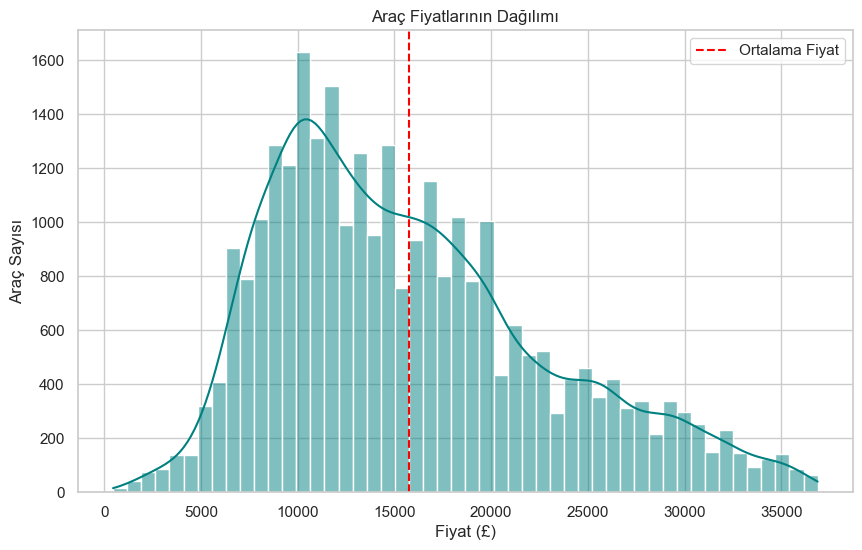

In [5]:
# fiyat dağılım grafiği
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['price'], bins=50, kde=True, color='teal')
plt.title('Araç Fiyatlarının Dağılımı')
plt.xlabel('Fiyat (£)')
plt.ylabel('Araç Sayısı')
plt.axvline(df_clean['price'].mean(), color='red', linestyle='--', label='Ortalama Fiyat')
plt.legend()
plt.show()

In [6]:
# ADVANCED modeller ile veri hazırlığı 
print("Advanced modeller için veri hazırlanıyor.")

df_adv = df_clean.copy()
#label encoding
cat_cols = df_adv.select_dtypes(include=['object']).columns
for col in cat_cols:
    df_adv[col] = df_adv[col].astype('category').cat.codes#her kelimeye bir sayı atar.

X_adv = df_adv.drop('price', axis=1) #özellikler
y_adv = df_adv['price'] #hedef

X_train_adv, X_test_adv, y_train_adv, y_test_adv = train_test_split(X_adv, y_adv, test_size=0.2, random_state=42)

print("Advanced veri seti ayrıldı:")
print(f"- Eğitim Seti (Train): {X_train_adv.shape}")
print(f"- Test Seti (Test)   : {X_test_adv.shape}")

Advanced modeller için veri hazırlanıyor.
Advanced veri seti ayrıldı:
- Eğitim Seti (Train): (22881, 16)
- Test Seti (Test)   : (5721, 16)


In [7]:
#  ADVANCED modellerin eğitimi 

if 'X_train_adv' not in locals() or 'y_train_adv' not in locals():
    raise ValueError("Advanced eğitim verisi bulunamadı")
    
print("Advanced modeller Hyperparameter Tuning ile eğitiliyor .")

# Modeller ve denenecek parametreler 
advanced_models = {
    "Random Forest": (RandomForestRegressor(random_state=42), {
        'model__n_estimators': [100, 200], #dikilecek ağaç sayısı
        'model__max_depth': [None, 10], # derinlik 
        'model__min_samples_split': [2, 5] #Bir dalın bölünmesi için gereken min. 
    }),
    "XGBoost": (XGBRegressor(random_state=42), {
        'model__n_estimators': [100, 200], #hata düzetlme işleminin kaç kez tekrarlanacağı 
        'model__learning_rate': [0.05, 0.1], #Her adımda modelin hatalardan ne kadar hızlı ders çıkaracağını belirler.
        'model__max_depth': [3, 6]
    })
}

advanced_results = []
best_params_report = {}

for name, (model, params) in advanced_models.items():
    pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')), #boşluklar dolar
        ('scaler', StandardScaler()), #veri ölçeklenir
        ('model', model) #en son model girer 
    ])
    
    # GridSearchCV ile optimum parametreleri buluyoruz
    grid_search = GridSearchCV(pipe, params, cv=3, scoring='r2', n_jobs=-1)
    #cv=3 Veriyi 3 parçaya böler. 2 parçayla eğitir, 1 parçayla test eder.
    grid_search.fit(X_train_adv, y_train_adv)
    
    # En iyi modeli alıyoruz
    best_model = grid_search.best_estimator_
    best_params_report[name] = grid_search.best_params_
    
    # Tahmin etme
    y_pred = best_model.predict(X_test_adv)
    
    # Skorlama 
    r2 = r2_score(y_test_adv, y_pred)
    mae = mean_absolute_error(y_test_adv, y_pred)
    mse = mean_squared_error(y_test_adv, y_pred)
    rmse = np.sqrt(mse)
    
    advanced_results.append({
        "Model": name,
        "Yöntem": "GridSearch Optimized",
        "R2 Score": r2, 
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "saved_preds": y_pred, 
        "Optimum Parametreler": str(grid_search.best_params_)
    })

# Sonuç tablosu 
df_adv_results = pd.DataFrame(advanced_results)
print("\nAdvanced Model Sonuçları (Optimum Parametreler):")
display(df_adv_results.sort_values(by="R2 Score", ascending=False).style.background_gradient(cmap="Blues"))

print("\n EN OPTİMUM PARAMETRELER")
for model_name, p in best_params_report.items(): 
    print(f"{model_name}: {p}")

Advanced modeller Hyperparameter Tuning ile eğitiliyor .

Advanced Model Sonuçları (Optimum Parametreler):


,Model,Yöntem,R2 Score,MAE,MSE,RMSE,saved_preds,Optimum Parametreler
1,XGBoost,GridSearch Optimized,0.944769,1190.904497,2798453.624025,1672.857921,[17391.395 14769.866 27239.154 ... 10125.079 32049.76 13734.394],"{'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__n_estimators': 200}"
0,Random Forest,GridSearch Optimized,0.938969,1201.229772,3092298.315074,1758.493194,[20296.0089504 15525.07991667 25324.92444628 ... 9049.02705628 29069.59996284 13979.87555952],"{'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 200}"



 EN OPTİMUM PARAMETRELER
Random Forest: {'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 200}
XGBoost: {'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__n_estimators': 200}


In [8]:
# feature engineering
# veriden yeni anlamlı özellikler türetiyoruz. 

if 'df_clean' in locals():
    df_eng = df_clean.copy()
else:
    print("df_clean bulunamadı, işlemler atlanıyor.")
    df_eng = pd.DataFrame()

df_eng['mileage'] = pd.to_numeric(df_eng['mileage'], errors='coerce')
print("Özellik mühendisliği başlıyor.")

# yeni özellikler türetiyorum
df_eng['age'] = 2025 - df_eng['year']
df_eng['avg_km_per_year'] = df_eng['mileage'] / df_eng['age'].replace(0, 1)
print("Yeni özellikler eklendi: 'age', 'avg_km_per_year'")

Özellik mühendisliği başlıyor.
Yeni özellikler eklendi: 'age', 'avg_km_per_year'


In [9]:
# türetme sonrası temizlik
df_eng = df_eng.drop(columns=['year'])
limit = len(df_eng) * 0.5
df_eng = df_eng.dropna(thresh=limit, axis=1) #yarısı dolu değilse o sütunu sil.
df_eng.replace([np.inf, -np.inf], np.nan, inplace=True)
#inf pozitif sonsuzluk - negatif sonsuzluk aracın yaşı 0  ise hata vermesin diye Nan yapma

kritik_sutunlar = ['price', 'age', 'mileage', 'avg_km_per_year']
mevcut_kritik = [col for col in kritik_sutunlar if col in df_eng.columns]
df_eng.dropna(subset=mevcut_kritik, inplace=True)

print(f"İşlem sonrası veri boyutu: {df_eng.shape}")
print("\nYeni özelliklerle veri seti örneği:")
display(df_eng[['price', 'age', 'mileage', 'avg_km_per_year']].head())

İşlem sonrası veri boyutu: (28357, 11)

Yeni özelliklerle veri seti örneği:


,price,age,mileage,avg_km_per_year
0,21990.0,6.0,563.0,93.833333
1,20498.0,9.0,33657.0,3739.666667
3,8690.0,6.0,2438.0,406.333333
4,34498.0,5.0,4623.0,924.600000
5,6495.0,12.0,51503.0,4291.916667


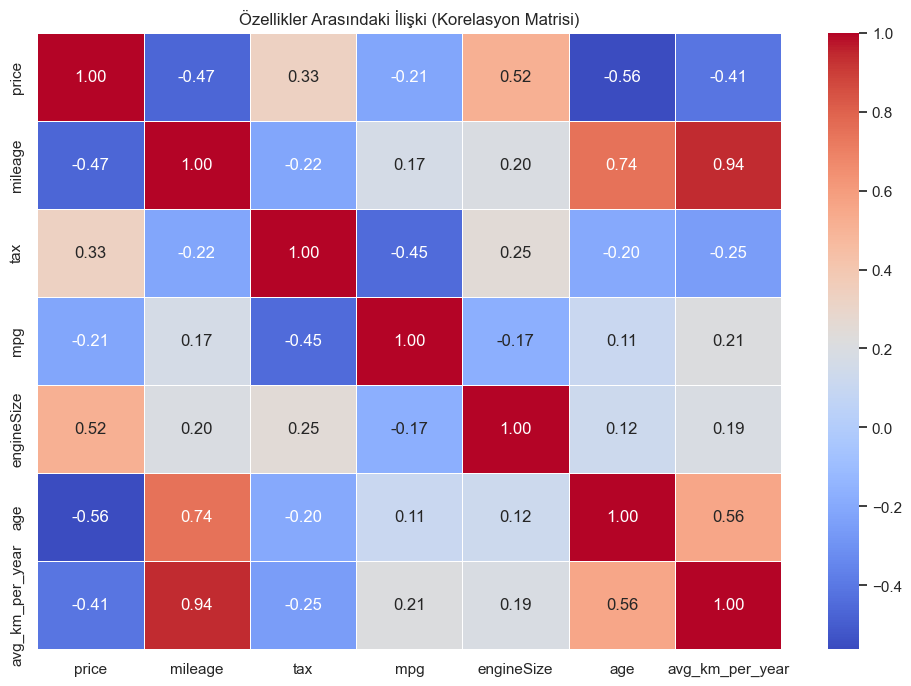

In [10]:
# Korelasyon Analizi 
plt.figure(figsize=(12, 8))
numeric_cols = df_eng.select_dtypes(include=np.number)
sns.heatmap(numeric_cols.corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Özellikler Arasındaki İlişki (Korelasyon Matrisi)')
plt.show()

In [11]:
## modelin kategorik verileri daha iyi anlaması için One-Hot Encoding yapıyorum.
print("One-Hot Encoding yapılıyor.")

if 'df_eng' in locals() and len(df_eng) > 0:
    df_model = df_eng.copy()
else:
    df_model = df_clean.copy()

df_encoded = pd.get_dummies(df_model, drop_first=True)
#get_dumines 0 ve 1 lerden oluşan yeni sütuna dönüştürür.
X = df_encoded.drop('price', axis=1)
y = df_encoded['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nVeri seti başarıyla hazırlandı ve bölündü:")
print(f"- Eğitim Seti Boyutu (X_train): {X_train.shape}")
print(f"- Test Seti Boyutu  (X_test) : {X_test.shape}")

One-Hot Encoding yapılıyor.

Veri seti başarıyla hazırlandı ve bölündü:
- Eğitim Seti Boyutu (X_train): (22685, 189)
- Test Seti Boyutu  (X_test) : (5672, 189)


In [12]:
#  ADVANCED modellerin farklı işlemlerde karşılaştırılamsı

print("Advanced modeller Tuning ile farklı veri setleri üzerinde test ediliyor.")

# Ölçeklendirme ve Imputer 
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(imputer.fit_transform(X_train))
X_test_scaled = scaler.transform(imputer.transform(X_test))

# SelectKBest (10)
selector = SelectKBest(score_func=f_regression, k=10)
X_train_sel = selector.fit_transform(X_train_scaled, y_train)
X_test_sel = selector.transform(X_test_scaled)

# PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

datasets = {
    "1. Tüm Özellikler (Scaled)": (X_train_scaled, X_test_scaled),
    "2. SelectKBest (10 Özellik)": (X_train_sel, X_test_sel),
    "3. PCA (İndirgenmiş)": (X_train_pca, X_test_pca)
}

tuning_params = {
    "Random Forest": {'n_estimators': [100, 200], 'max_depth': [10, None]},
    "XGBoost": {'n_estimators': [100, 200], 'learning_rate': [0.1]}
}

advanced_final_results = []

for model_name, model_obj in {"Random Forest": RandomForestRegressor(random_state=42), 
                              "XGBoost": XGBRegressor(random_state=42)}.items():
    for data_name, (X_tr, X_te) in datasets.items():
        print(f"Eğitiliyor: {model_name} - {data_name}")
        
        # Hyperparameter Tuning
        grid = GridSearchCV(model_obj, tuning_params[model_name], cv=3, n_jobs=-1)
        grid.fit(X_tr, y_train)
        
        best_m = grid.best_estimator_
        preds = best_m.predict(X_te)
        
        r2 = r2_score(y_test, preds)
        mae = mean_absolute_error(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        
        advanced_final_results.append({
            "Model": model_name,
            "Yöntem": data_name,
            "R2 Score": r2,
            "MAE": mae,
            "RMSE": rmse, 
            "Özellik Sayısı": X_tr.shape[1],
            "saved_preds": preds, 
            "Optimum Parametre": str(grid_search.best_params_)
        })

df_adv_final_results = pd.DataFrame(advanced_final_results)
display(df_adv_final_results.sort_values(by="R2 Score", ascending=False))

Advanced modeller Tuning ile farklı veri setleri üzerinde test ediliyor.
Eğitiliyor: Random Forest - 1. Tüm Özellikler (Scaled)
Eğitiliyor: Random Forest - 2. SelectKBest (10 Özellik)
Eğitiliyor: Random Forest - 3. PCA (İndirgenmiş)
Eğitiliyor: XGBoost - 1. Tüm Özellikler (Scaled)
Eğitiliyor: XGBoost - 2. SelectKBest (10 Özellik)
Eğitiliyor: XGBoost - 3. PCA (İndirgenmiş)


,Model,Yöntem,R2 Score,MAE,RMSE,Özellik Sayısı,saved_preds,Optimum Parametre
5,XGBoost,3. PCA (İndirgenmiş),0.932926,1309.513199,1853.711984,157,"[13763.777, 16828.578, 21279.303, 15839.408, 2...","{'model__learning_rate': 0.1, 'model__max_dept..."
3,XGBoost,1. Tüm Özellikler (Scaled),0.932539,1336.507653,1859.045895,189,"[12924.149, 17691.285, 20449.723, 15599.43, 24...","{'model__learning_rate': 0.1, 'model__max_dept..."
0,Random Forest,1. Tüm Özellikler (Scaled),0.931548,1292.071018,1872.647633,189,"[13792.82, 17018.55, 21479.075, 15252.235, 227...","{'model__learning_rate': 0.1, 'model__max_dept..."
2,Random Forest,3. PCA (İndirgenmiş),0.920680,1375.920192,2015.834680,157,"[14057.765, 16172.1, 21627.115, 15751.505, 181...","{'model__learning_rate': 0.1, 'model__max_dept..."
4,XGBoost,2. SelectKBest (10 Özellik),0.862076,1953.977818,2658.176847,10,"[11788.496, 17045.43, 19686.969, 15044.294, 27...","{'model__learning_rate': 0.1, 'model__max_dept..."
1,Random Forest,2. SelectKBest (10 Özellik),0.855527,2011.090415,2720.550212,10,"[12083.272803956932, 17760.101629787056, 19737...","{'model__learning_rate': 0.1, 'model__max_dept..."


In [13]:
#  PYTORCH derin öğrenme modelleri

# 1. Y (Fiyat) Değişkenini Ölçeklendirme Negatif R2 almasını engelledim.
y_scaler = StandardScaler()
y_train_reshaped = y_train.values.reshape(-1, 1)
y_train_scaled_np = y_scaler.fit_transform(y_train_reshaped)
# çok büyük sayısal değerlerle  eğitilirken matematiksel olarak kararsızlaşabilir.
# skorunun negatif çıkmasına neden olur. 
#Çıktıyı küçülterek modelin daha hızlı ve doğru öğrenmesini sağlıyoruz.

# Tensorları Hazırlama
X_train_pt = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_pt = torch.tensor(y_train_scaled_np, dtype=torch.float32)
X_test_pt = torch.tensor(X_test_scaled, dtype=torch.float32)

# Modelleri Tanımlama 
class ModelV1(nn.Module): #3 katmanlı basit bir ağ.
    def __init__(self, input_dim):
        super(ModelV1, self).__init__()
        self.net = nn.Sequential(nn.Linear(input_dim, 64), nn.ReLU(), nn.Linear(64, 32), nn.ReLU(), nn.Linear(32, 1))
    def forward(self, x): return self.net(x)

class ModelV2(nn.Module): #Daha derin ve güvenli bir ağ
    def __init__(self, input_dim):
        super(ModelV2, self).__init__()
        self.net = nn.Sequential(nn.Linear(input_dim, 128), nn.ReLU(), nn.Dropout(0.2), nn.Linear(128, 64), nn.ReLU(), nn.Linear(64, 32), nn.ReLU(), nn.Linear(32, 1))
    def forward(self, x): return self.net(x)

def train_pytorch_model(model, X, y, epochs=150, lr=0.001):
    #epochs devir sayısı.tüm veri setini baştan sona kaç kez göreceğidir.
    #lr modelin bir hatadan ne kadar büyük ders çıkaracağını belirler.bir adım büyüklüğü 
    criterion = nn.MSELoss() #hata ölçer tahmin edilen fiyat ile gerçek fiyat arasındakş farkın karesi alınır.
    optimizer = optim.Adam(model.parameters(), lr=lr) #Modelin ağırlıklarını hatayı azaltacak şekilde günceller.
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad() #hafızayı sıfırlar.
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward() #Hangi nöronun ne kadar suçlu olduğunu hesaplar.
        optimizer.step() #Nöronların ağırlıklarını bir adım ileri taşır.
    return model


advanced_final_results = [m for m in advanced_final_results if m['Yöntem'] != "PyTorch DL"]

input_dim = X_train_pt.shape[1]
pt_models = {"PyTorch MLP v1 (Standart)": ModelV1(input_dim), "PyTorch Deep v2 (Gelişmiş)": ModelV2(input_dim)}

print("PyTorch modelleri eğitiliyor.")
for name, model_obj in pt_models.items():
    trained_model = train_pytorch_model(model_obj, X_train_pt, y_train_pt)
    trained_model.eval()
    with torch.no_grad():
        # Tahmin al ve inverse transform ile gerçek fiyatlara (£) geri dön
        preds_scaled = trained_model(X_test_pt).numpy()
        preds = y_scaler.inverse_transform(preds_scaled).flatten()
        #Model bize ölçeklenmiş (0.5, -0.2 gibi) değerler verir.
        #Biz bunları y_scaler kullanarak tekrar gerçek fiyat birimine  çeviriyoruz.
    
    # Metrikleri Hesapla
    r = r2_score(y_test, preds)
    m = mean_absolute_error(y_test, preds)
    ma = mean_absolute_percentage_error(y_test, preds)
    
    advanced_final_results.append({
        "Model": name, "Yöntem": "PyTorch DL", "R2 Score": r, "MAE": m,
        "RMSE": np.sqrt(mean_squared_error(y_test, preds)), "MAPE": ma,
        "saved_preds": preds, "Optimum Parametre": "Epoch: 150, LR: 0.001, Y-Scaled"
    })

print("İşlem Tamamlandı.")

PyTorch modelleri eğitiliyor.
İşlem Tamamlandı.


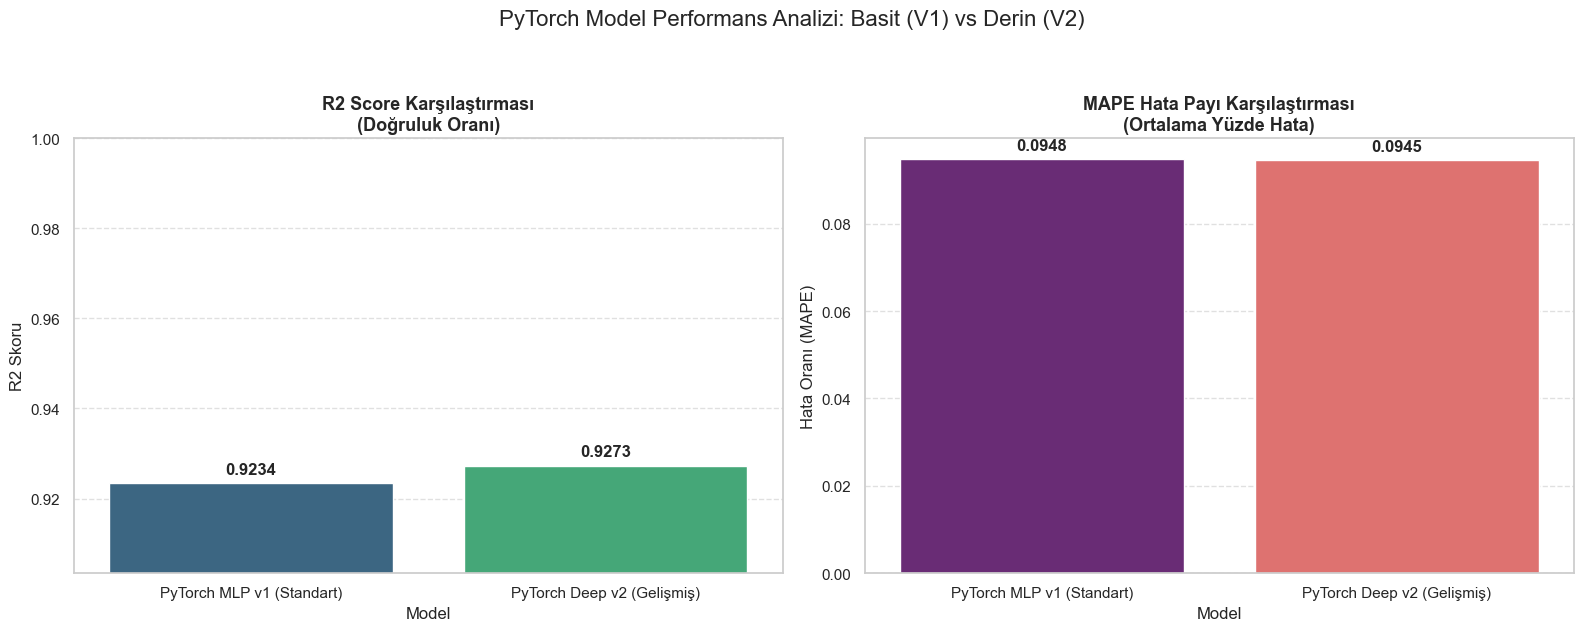

In [34]:
df_metrics = pd.DataFrame(advanced_final_results)
df_pytorch_only = df_metrics[df_metrics['Yöntem'] == 'PyTorch DL'].copy()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# R2 skor
sns.barplot(x='Model', y='R2 Score', data=df_pytorch_only, ax=axes[0], palette='viridis', hue='Model', legend=False)
axes[0].set_title('R2 Score Karşılaştırması\n(Doğruluk Oranı)', fontsize=13, fontweight='bold')
axes[0].set_ylabel('R2 Skoru')

# 
min_r2 = df_pytorch_only['R2 Score'].min()
axes[0].set_ylim(min_r2 - 0.02, 1.0) 
axes[0].grid(axis='y', linestyle='--', alpha=0.6)

# Barların üzerine değer yazma
for p in axes[0].patches:
    axes[0].annotate(f"{p.get_height():.4f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontweight='bold')


# MAPE
sns.barplot(x='Model', y='MAPE', data=df_pytorch_only, ax=axes[1], palette='magma', hue='Model', legend=False)
axes[1].set_title('MAPE Hata Payı Karşılaştırması\n(Ortalama Yüzde Hata)', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Hata Oranı (MAPE)')
axes[1].grid(axis='y', linestyle='--', alpha=0.6)

# Barların üzerine değer yazma
for p in axes[1].patches:
    axes[1].annotate(f"{p.get_height():.4f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontweight='bold')

plt.suptitle('PyTorch Model Performans Analizi: Basit (V1) vs Derin (V2)', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

In [17]:
# TÜM MODELLERİN KARŞILAŞTIRILMASI 

#  Vize skorlarını tanımlıyoruz.
vize_base_results = [
    {"Model": "Decision Tree (Base)", "Yöntem": "Vize Ödevi", "R2 Score": 0.886618, "MAE": 1825.328, "RMSE": np.nan, "MAPE": np.nan},
    {"Model": "Bayesian Ridge (Base)", "Yöntem": "Vize Ödevi", "R2 Score": 0.708180, "MAE": 3550.245, "RMSE": np.nan, "MAPE": np.nan}
]

# Üç farklı kaynaktan verileri birleştiriyoruz
df_vize = pd.DataFrame(vize_base_results)
df_advanced = pd.DataFrame(advanced_final_results)
df_high_scores = pd.DataFrame(advanced_results)

if 'R2 Skoru' in df_high_scores.columns:
    df_high_scores = df_high_scores.rename(columns={'R2 Skoru': 'R2 Score'})
if 'Yöntem' not in df_high_scores.columns:
    df_high_scores['Yöntem'] = "Ham Veri (Label Encoded)"

df_grand_final = pd.concat([df_vize, df_advanced, df_high_scores], ignore_index=True)
df_champions = df_grand_final.sort_values(by="R2 Score", ascending=False).drop_duplicates(subset=["Model"])

print("\n MODELİN EN İYİ PERFORMANS KARŞILAŞTIRMASI ")
display(df_champions.sort_values(by="R2 Score", ascending=False).style
    .highlight_max(subset=['R2 Score'], color='lightgreen') 
    .format({"R2 Score": "{:.4f}", "MAE": "{:.2f}", "MAPE": "{:.4f}"}, na_rep="-"))




 MODELİN EN İYİ PERFORMANS KARŞILAŞTIRMASI 


,Model,Yöntem,R2 Score,MAE,RMSE,MAPE,Özellik Sayısı,saved_preds,Optimum Parametre,MSE,Optimum Parametreler
11,XGBoost,GridSearch Optimized,0.9448,1190.90,1672.857921,-,-,[17391.395 14769.866 27239.154 ... 10125.079 32049.76 13734.394],-,2798453.624025,"{'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__n_estimators': 200}"
10,Random Forest,GridSearch Optimized,0.9390,1201.23,1758.493194,-,-,[20296.0089504 15525.07991667 25324.92444628 ... 9049.02705628 29069.59996284 13979.87555952],-,3092298.315074,"{'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 200}"
9,PyTorch Deep v2 (Gelişmiş),PyTorch DL,0.9273,1388.12,1930.116560,0.0945,-,[13005.036 17447.887 19878.406 ... 22685.074 19984.318 27042.598],"Epoch: 150, LR: 0.001, Y-Scaled",-,-
8,PyTorch MLP v1 (Standart),PyTorch DL,0.9234,1414.65,1980.675854,0.0948,-,[13082.611 17043.246 20389.855 ... 23417.812 20282.85 27234.217],"Epoch: 150, LR: 0.001, Y-Scaled",-,-
0,Decision Tree (Base),Vize Ödevi,0.8866,1825.33,-,-,-,-,-,-,-
1,Bayesian Ridge (Base),Vize Ödevi,0.7082,3550.24,-,-,-,-,-,-,-


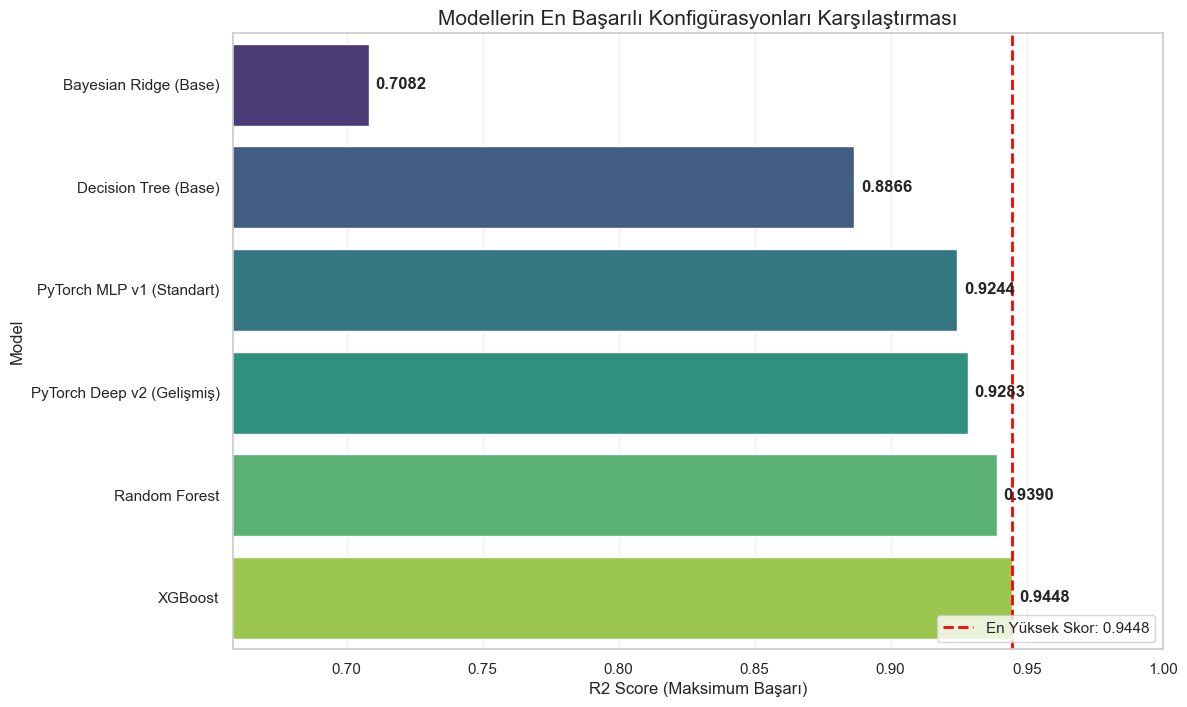

In [20]:
#  görselleştirme
plt.figure(figsize=(12, 8))
df_champions = df_champions.sort_values(by='R2 Score', ascending=True) # Grafikte en iyi en üstte çıksın diye
ax = sns.barplot(x='R2 Score', y='Model', data=df_champions, palette='viridis')

# en yüksek skoru bul ve dikey çizgi çek
max_r2 = df_champions['R2 Score'].max()
plt.axvline(x=max_r2, color='red', linestyle='--', linewidth=2, label=f'En Yüksek Skor: {max_r2:.4f}')

# Barların üzerine değer yazma
for p in ax.patches:
    ax.annotate(f"{p.get_width():.4f}", (p.get_width(), p.get_y() + p.get_height()/2.),
                ha='left', va='center', xytext=(5, 0), textcoords='offset points', fontweight='bold')

plt.title('Modellerin En Başarılı Konfigürasyonları Karşılaştırması', fontsize=15)
plt.xlabel('R2 Score (Maksimum Başarı)', fontsize=12)
plt.xlim(min(df_champions['R2 Score']) - 0.05, 1.0)
plt.legend(loc='lower right')
plt.grid(axis='x', alpha=0.3)
plt.show()


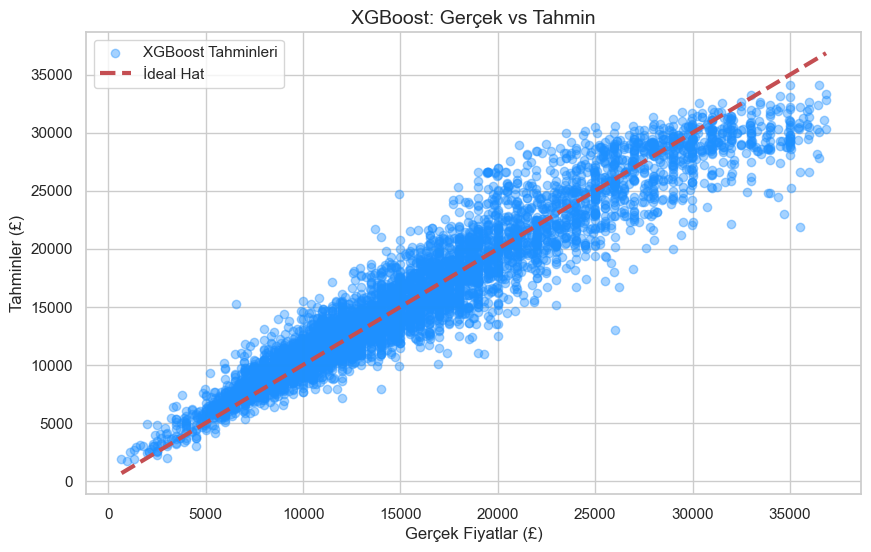

In [25]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

xgb_preds = xgb_model.predict(X_test_scaled)

plt.figure(figsize=(10, 6))
actual = np.array(y_test).flatten()
preds = np.array(xgb_preds).flatten()

plt.scatter(actual, preds, alpha=0.4, color='dodgerblue', label='XGBoost Tahminleri')
lims = [min(actual.min(), preds.min()), max(actual.max(), preds.max())]
plt.plot(lims, lims, 'r--', lw=3, label='İdeal Hat')

plt.title('XGBoost: Gerçek vs Tahmin', fontsize=14)
plt.xlabel('Gerçek Fiyatlar (£)')
plt.ylabel('Tahminler (£)')
plt.legend()
plt.show()

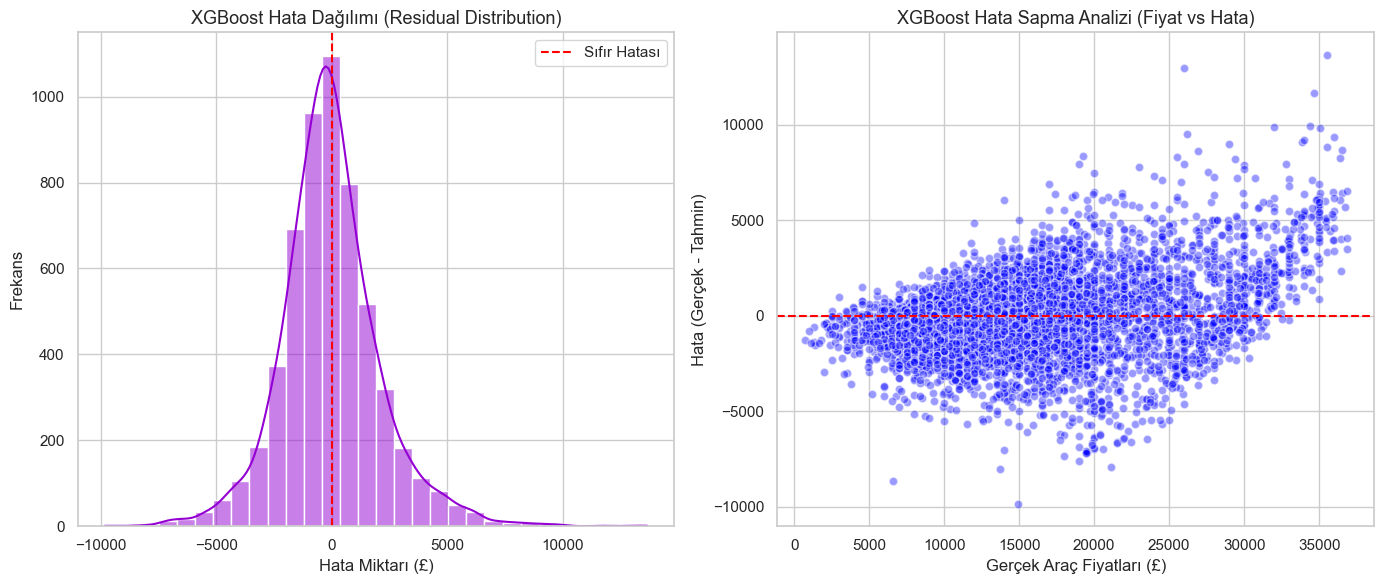

In [26]:
best_preds = xgb_model.predict(X_test_scaled)

# Verileri düzleştir ve hataları hesapla
actual = np.array(y_test).flatten()
best_preds = best_preds.flatten()
errors = actual - best_preds

#  Görselleştirme
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(errors, kde=True, color='darkviolet', bins=30)
plt.axvline(x=0, color='red', linestyle='--', label='Sıfır Hatası')
plt.title('XGBoost Hata Dağılımı (Residual Distribution)', fontsize=13)
plt.xlabel('Hata Miktarı (£)')
plt.ylabel('Frekans')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(actual, errors, alpha=0.4, color='blue', edgecolors='w')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('XGBoost Hata Sapma Analizi (Fiyat vs Hata)', fontsize=13)
plt.xlabel('Gerçek Araç Fiyatları (£)')
plt.ylabel('Hata (Gerçek - Tahmin)')

# Grafiklerin birbirine girmesini engelle
plt.tight_layout()
plt.show()

Analiz ediliyor: XGBoost (1. Tüm Özellikler (Scaled))


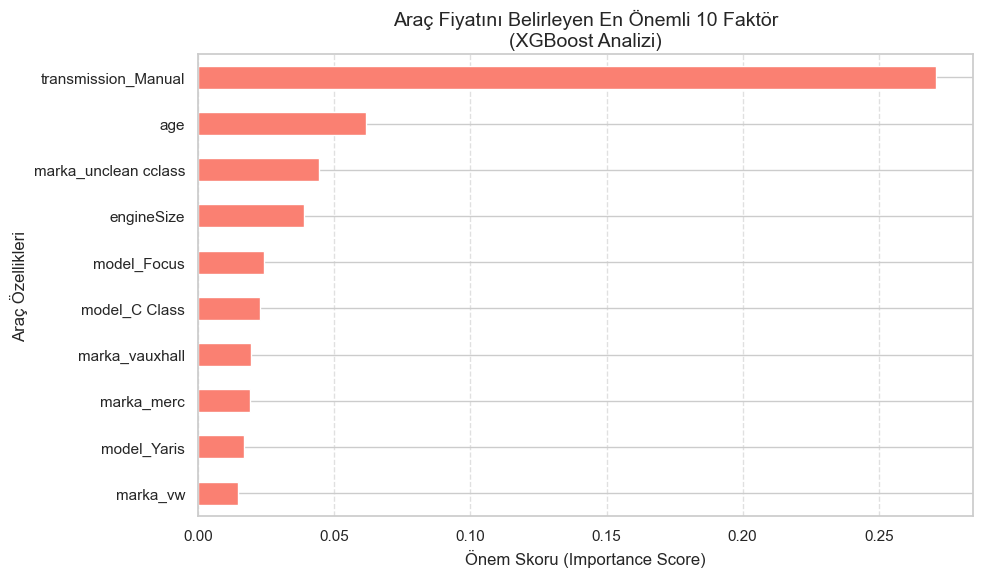

 Modelimiz araç fiyatını etkileyen en kritik faktörün 'transmission_Manual' olduğunu saptamıştır.


In [28]:
# Araç fiyatını en çok etkileyenler 

# özellik isimlerini içeren  yöntemiyle eğitilmiş en iyi modeli bulalım
target_method = "1. Tüm Özellikler (Scaled)"
df_filtered = df_grand_final[df_grand_final['Yöntem'] == target_method]

if not df_filtered.empty:
    # Bu yöntemle eğitilmiş en iyi modeli seçiyoruz
    best_row = df_filtered.sort_values(by="R2 Score", ascending=False).iloc[0]
    best_model_name = best_row['Model']
    
    # Eğer best_m hala o modelse  çalışacaktır.
    # Aksi takdirde, Scaled veri setiyle eğitilen modeli tekrar hızlıca fit etmeliyiz:
    
    print(f"Analiz ediliyor: {best_model_name} ({target_method})")
    
    if "XGBoost" in best_model_name:
        analysis_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    else:
        analysis_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    
    analysis_model.fit(X_train_scaled, y_train)
    
    # Önem skorlarını al ve X_train sütunlarıyla eşleştir
    # X_train_scaled sütun sayısı ile X_train.columns sayısının aynı olduğundan emin oluyoruz
    importances = analysis_model.feature_importances_
    
    # Hata almamak için sütun sayısını kontrol ediyoruz
    column_names = X_train.columns if len(X_train.columns) == len(importances) else [f"Feature_{i}" for i in range(len(importances))]
    
    feat_importances = pd.Series(importances, index=column_names).nlargest(10)

    #  görselleştirme
    plt.figure(figsize=(10, 6))
    feat_importances.sort_values().plot(kind='barh', color='salmon')
    plt.title(f'Araç Fiyatını Belirleyen En Önemli 10 Faktör\n({best_model_name} Analizi)', fontsize=14)
    plt.xlabel('Önem Skoru (Importance Score)', fontsize=12)
    plt.ylabel('Araç Özellikleri', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()
    
    
    top_feature = feat_importances.idxmax()
    print(f" Modelimiz araç fiyatını etkileyen en kritik faktörün '{top_feature}' olduğunu saptamıştır.")
else:
    print("Hata: 'Tüm Özellikler (Scaled)' yöntemiyle eğitilmiş model bulunamadı.")

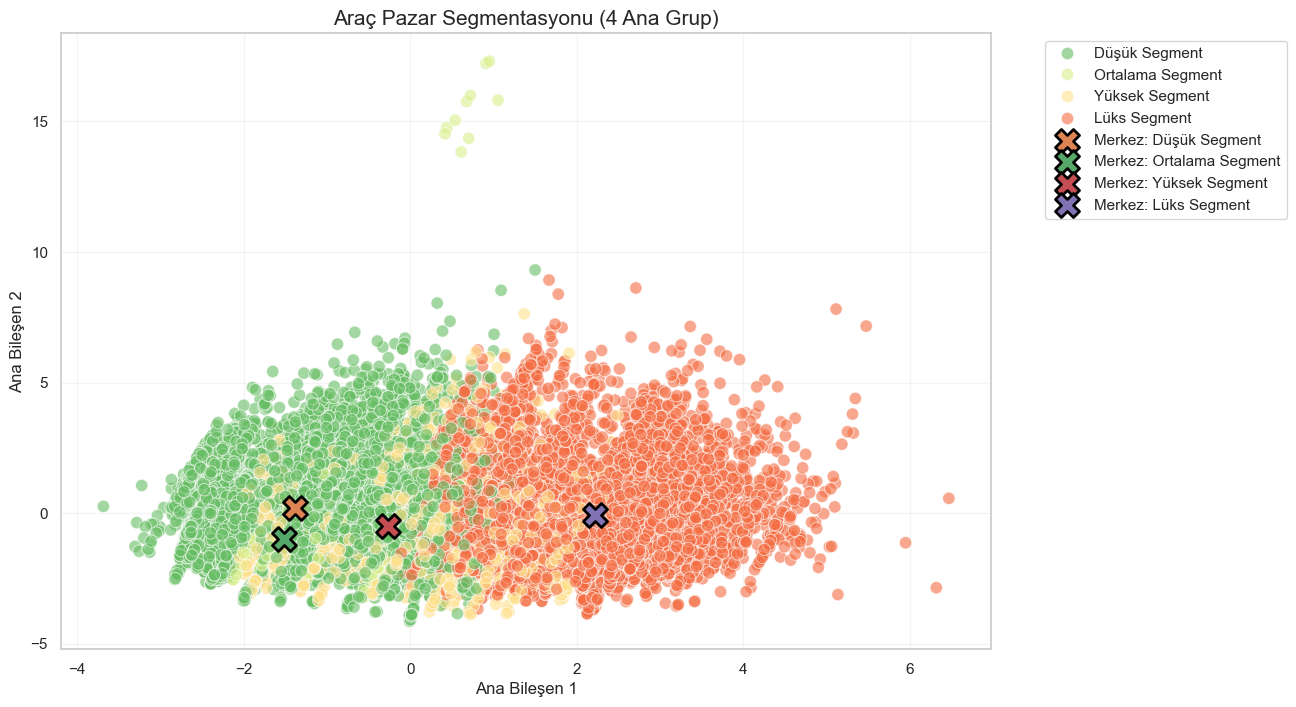

Segment Dağılımı:
 Segment
Düşük Segment       11528
Lüks Segment         7827
Yüksek Segment       2891
Ortalama Segment      439
Name: count, dtype: int64


In [32]:
#  K-MEANS Uygulaması 
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_input)

#  PCA ile 2 Boyuta İndirgeme
pca_viz = PCA(n_components=2)
pca_2d = pca_viz.fit_transform(X_input)

cluster_names = {
    0: "Düşük Segment",
    1: "Ortalama Segment",
    2: "Yüksek Segment",
    3: "Lüks Segment"
}

# görselleştirme tablosu
df_viz = pd.DataFrame(pca_2d, columns=['Bileşen 1', 'Bileşen 2'])
df_viz['Küme'] = cluster_labels
df_viz['Segment'] = df_viz['Küme'].map(cluster_names)

# görselleştirme
plt.figure(figsize=(12, 8))

# Kümelerin Dağılımı
sns.scatterplot(
    x='Bileşen 1', y='Bileşen 2', 
    hue='Segment', 
    hue_order=["Düşük Segment", "Ortalama Segment", "Yüksek Segment", "Lüks Segment"],
    data=df_viz, 
    palette='RdYlGn_r', # Kırmızıdan Yeşile (Düşükten Lükse) bir renk palet
    s=80, alpha=0.6
)

# Merkezlerin Belirlenmesi ve Çizimi
centers_pca = pca_viz.transform(kmeans.cluster_centers_)
for i, center in enumerate(centers_pca):
    plt.scatter(
        center[0], center[1], 
        marker='X', s=300, 
        edgecolor='black', linewidth=2,
        label=f'Merkez: {cluster_names[i]}'
    )

plt.title('Araç Pazar Segmentasyonu (4 Ana Grup)', fontsize=15)
plt.xlabel('Ana Bileşen 1')
plt.ylabel('Ana Bileşen 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.2)
plt.show()

# Küme Başına Veri Sayısı
print("Segment Dağılımı:\n", df_viz['Segment'].value_counts())

In [ ]:
Projem kapsamında uyguladığım makine öğrenmesi algoritmaları arasında XGBoost, elde ettiği 0.94 R2 skoru ile en yüksek başarıyı sergileyen model 
olmuştur. Bu başarının temel sebebi, XGBoost'un 'Gradient Boosting' (Gradyan Artırma) mantığıyla çalışarak hataları kademeli olarak minimize 
etmesidir. İkinci sırada yer alan Random Forest (RF) algoritması, ağaçları birbirinden bağımsız ve paralel (bagging) oluştururken; XGBoost,
her yeni ağacı bir önceki ağacın yaptığı hataları (residual) düzeltmek üzere sıralı bir şekilde kurgular. Bu 'zayıf öğrenicileri güçlü bir modele 
dönüştürme' stratejisi, projemdeki karmaşık ve doğrusal olmayan veri yapısını anlamlandırmada fark yaratmıştır.

In [ ]:
GridSearchCV ile optimize ettiğim learning_rate (öğrenme katsayısı) ve max_depth (derinlik) parametreleri, modelin veriye aşırı uyum (overfitting)
sağlamadan en derin korelasyonları yakalamasına olanak tanımıştır. Özellikle learning_rate değerini düşük tutarak modelin hatalardan daha 'temkinli'
ve 'hassas' ders çıkarmasını sağladım. PyTorch ile geliştirdiğim derin öğrenme modellerinin XGBoost'un gerisinde kalması ise beklenen bir durumdur; 
çünkü derin öğrenme yapıları genellikle çok daha büyük ve karmaşık veri setlerinde (görüntü, ses vb.) tam performans gösterirken, elimdeki tabular 
(tablo) veri seti için XGBoost gibi topluluk öğrenme (ensemble learning) yöntemleri çok daha verimli sonuçlar üretmektedir. Base modeller ise verideki
çok boyutlu ilişkileri yakalamakta yetersiz kalarak yüksek yanlılık (bias) göstermiş ve düşük başarıda kalmıştır. Sonuç olarak XGBoost, hem hesaplama
maliyeti hem de tahmin başarısı açısından bu projenin en optimize çözümü olmuştur."

In [ ]:
Yapmış olduğum kümelem işleminde verimi 4 ana başlıkta kmeansle böldüm.Bu segmentler Düşük Segment,Lüks Segment ,Yüksek Segment ,Ortalama Segmentdir.
